In [138]:

import matplotlib.pyplot as plt
%matplotlib notebook
import random
import numpy as np
import pandas as pd
from sklearn import datasets, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
import sklearn.linear_model as lm
import tensorflow as tf
#from tensorflow.contrib import skflow



In [97]:
# Read in train data
titanic_df = pd.read_csv('train.csv')#, 'titanic', index_col=None, na_values=['NA'])
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [182]:
print(titanic_df.count())
titanic_df['Survived'].mean()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


0.3838383838383838

### Do some crosstabs

In [99]:
pd.crosstab(titanic_df.Survived, titanic_df.Pclass, margins=False)

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


##### Pclass looks like a good variable

<IPython.core.display.Javascript object>


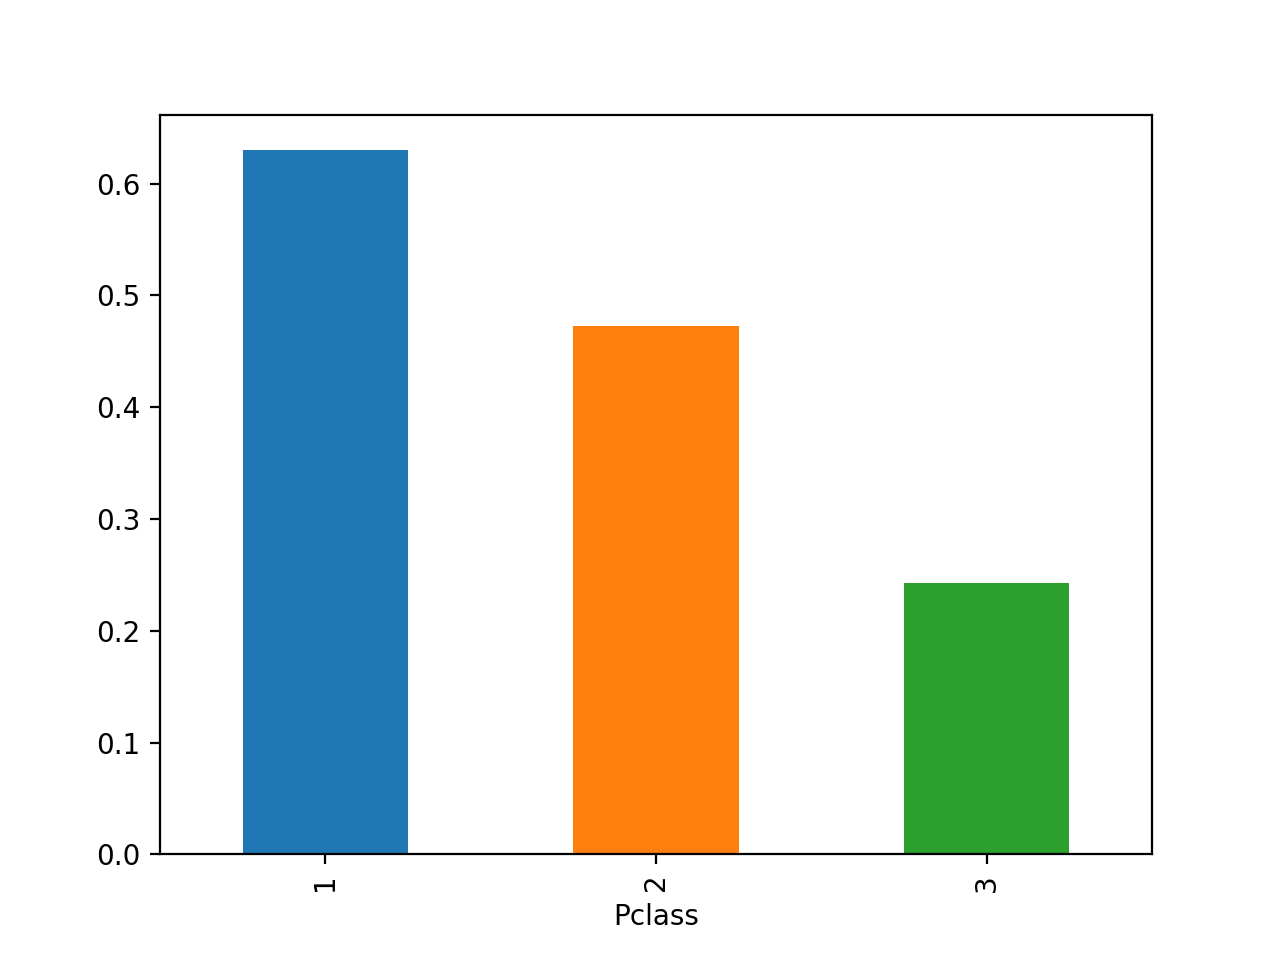

In [189]:
pclass_grouping = titanic_df.groupby('Pclass').mean()
pclass_grouping['Survived'].plot.bar()

In [100]:
pd.crosstab(titanic_df.Survived, titanic_df.Sex, margins=False)

Sex,female,male
Survived,,
0,81,468
1,233,109


##### Sex as well

In [101]:
pd.crosstab(titanic_df.Survived, titanic_df.SibSp, margins=True)

SibSp,0,1,2,3,4,5,8,All
Survived,,,,,,,,
0,398,97,15,12,15,5,7,549
1,210,112,13,4,3,0,0,342
All,608,209,28,16,18,5,7,891


<IPython.core.display.Javascript object>


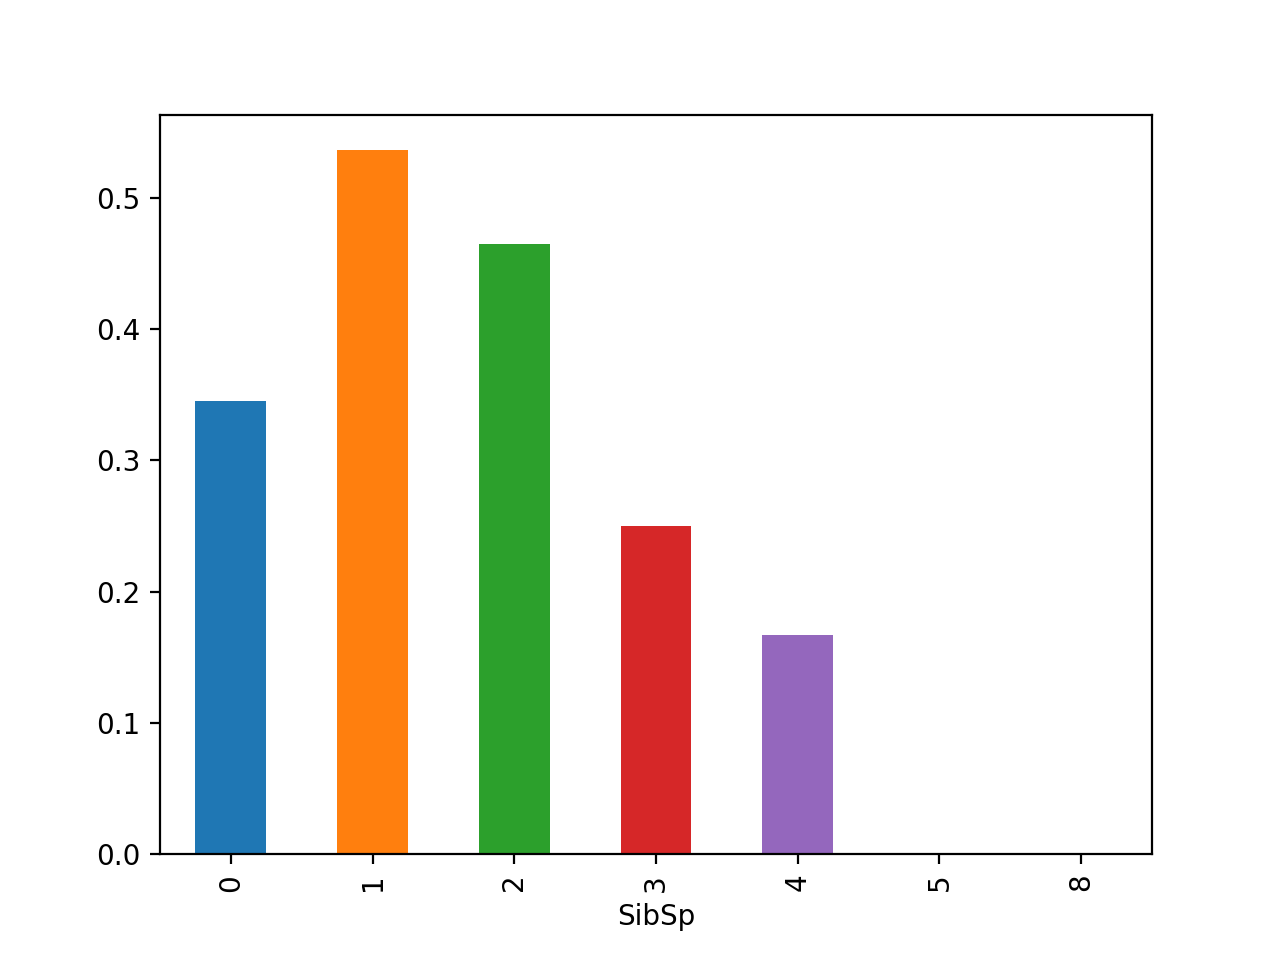

In [102]:
sibsp_grouping = titanic_df.groupby('SibSp').mean()
sibsp_grouping['Survived'].plot.bar()

<IPython.core.display.Javascript object>


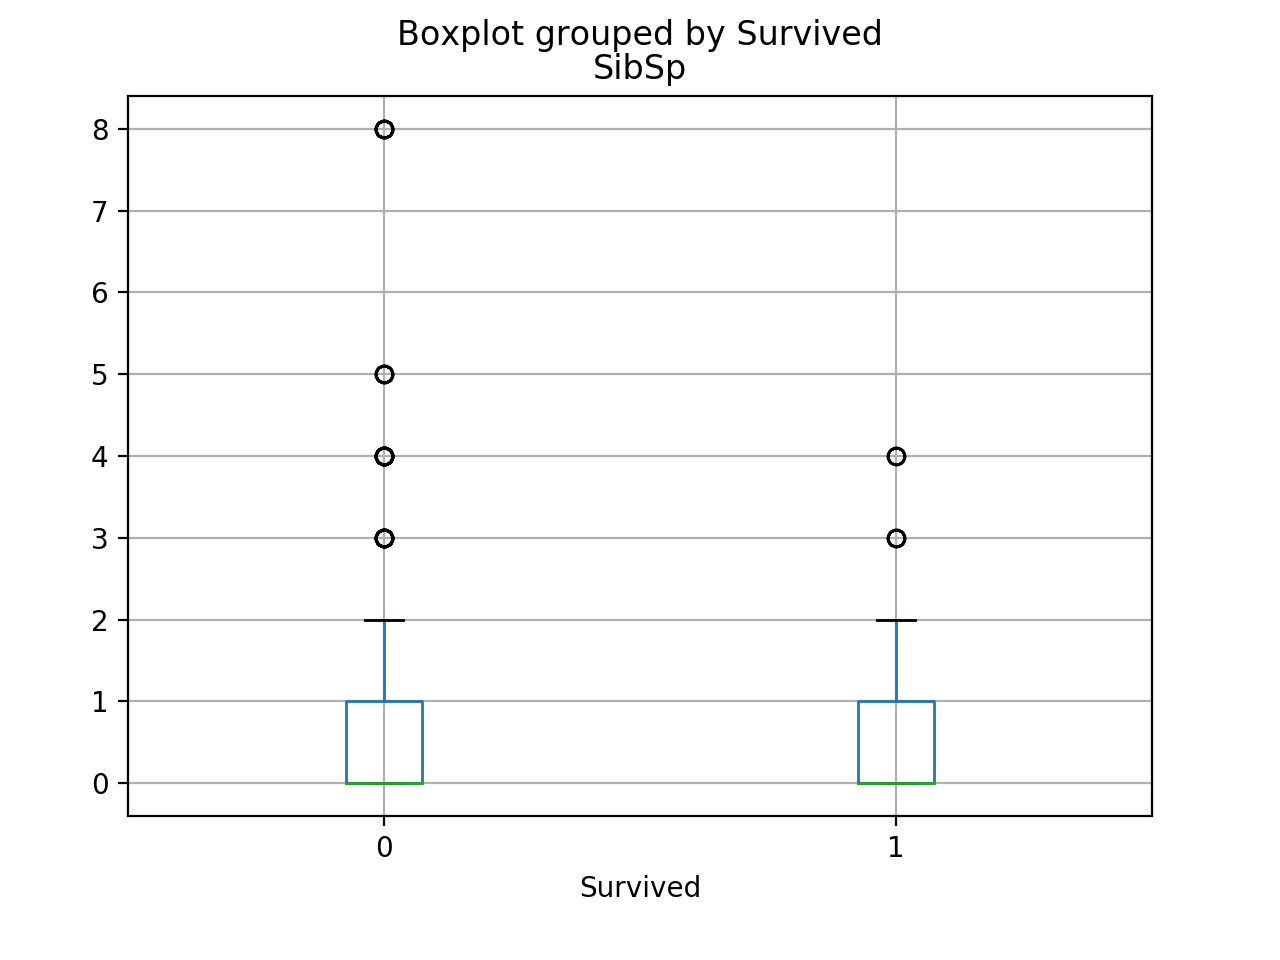

In [103]:
titanic_df.boxplot(column='SibSp',by='Survived')

In [21]:
pd.crosstab(titanic_df.Survived, titanic_df.Parch, margins=False)

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


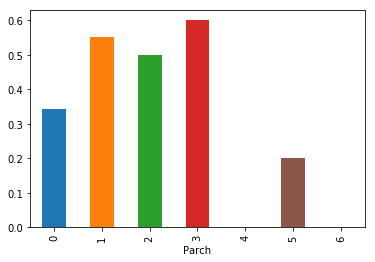

In [31]:
parch_grouping = titanic_df.groupby('Parch').mean()
parch_grouping['Survived'].plot.bar()

<IPython.core.display.Javascript object>


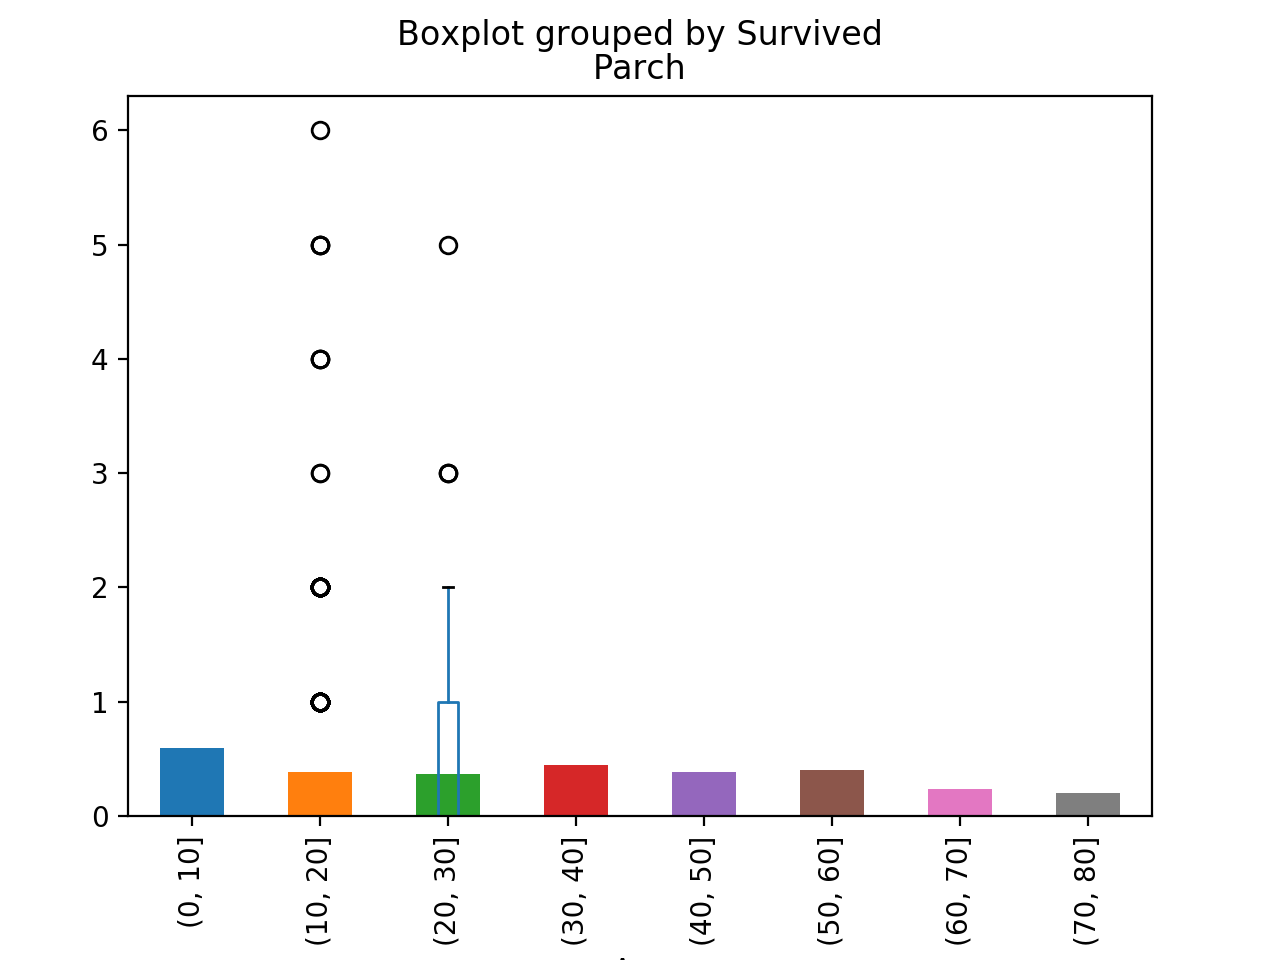

In [104]:
titanic_df.boxplot(column='Parch',by='Survived')

In [23]:
pd.crosstab(titanic_df.Survived, titanic_df.Embarked, margins=False)

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


##### Probably embarked too

<IPython.core.display.Javascript object>


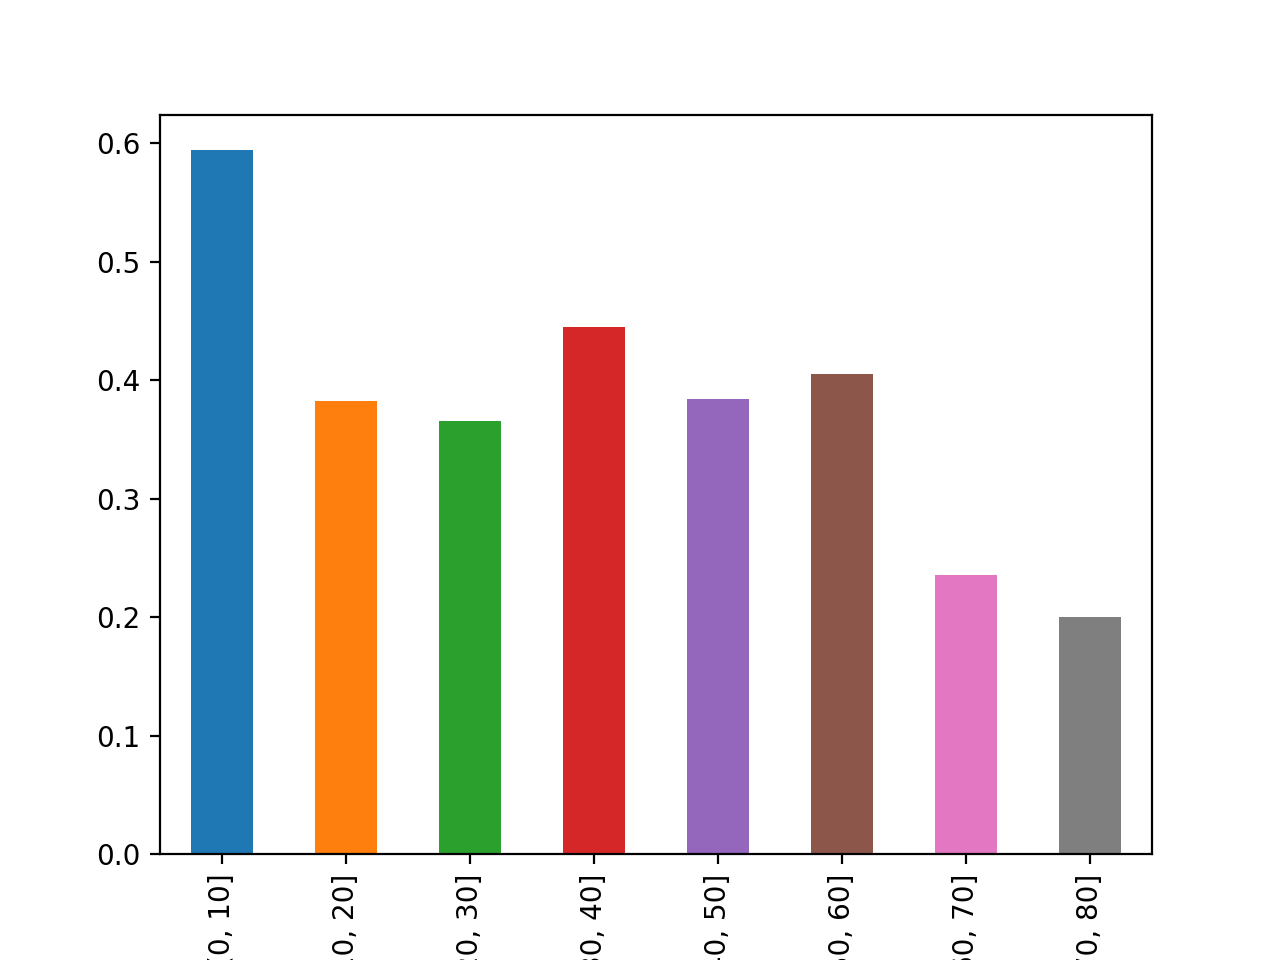

In [137]:
group_by_age = pd.cut(titanic_df['Age'], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['Survived'].plot.bar()

<IPython.core.display.Javascript object>


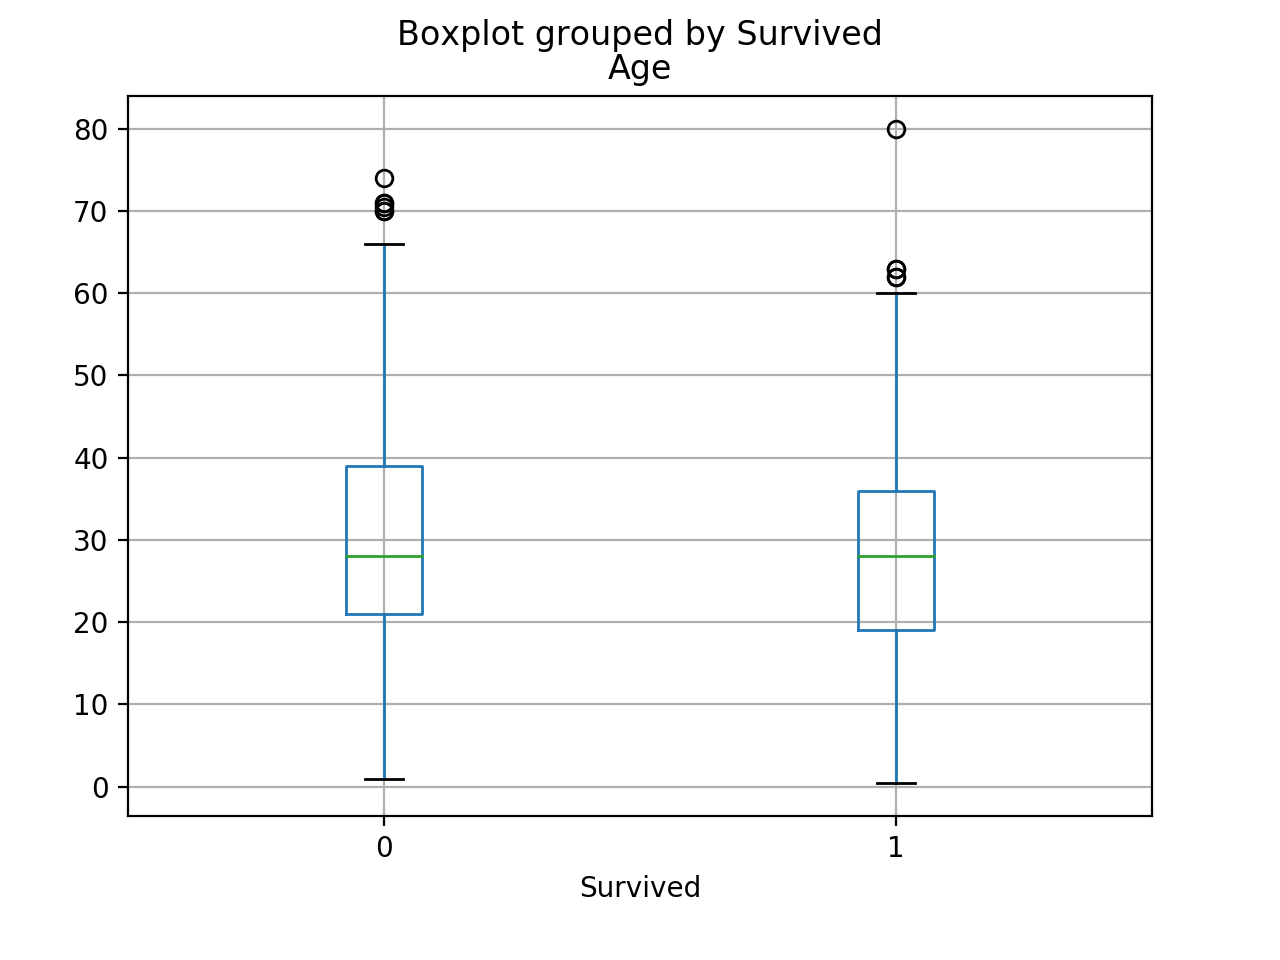

In [106]:
titanic_df.boxplot(column='Age',by='Survived')

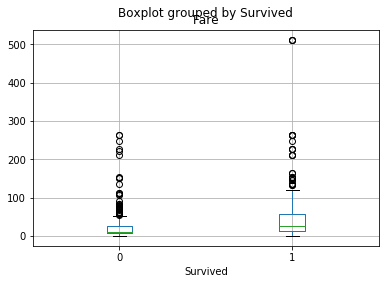

In [53]:
titanic_df.boxplot(column='Fare',by='Survived')

##### So we have:
- Pclass
- Sex
- Parch
- Embarked
- Fare

In [186]:
titanic_df['MoreThan2SibSp'] = titanic_df['SibSp'].apply(lambda sibsp: sibsp > 2)
#print(titanic_df.head(10))

In [190]:
titanic_df.count()

PassengerId       891
Survived          891
Pclass            891
Name              891
Sex               891
Age               714
SibSp             891
Parch             891
Ticket            891
Fare              891
Cabin             204
Embarked          889
MoreThan2SibSp    891
dtype: int64

##### We're going to have to dropna

In [191]:

def preprocess_titanic_df(df):
    processed_df = df.copy()
    processed_df = processed_df.drop(['Name','Age','Ticket','Cabin','SibSp'],axis=1)
    processed_df = processed_df.dropna()
    le = preprocessing.LabelEncoder()
    processed_df['Sex'] = le.fit_transform(processed_df.Sex)
    processed_df['Embarked'] = le.fit_transform(processed_df.Embarked)
    return processed_df

processed_df = preprocess_titanic_df(titanic_df)

In [192]:
processed_df.count()

PassengerId       889
Survived          889
Pclass            889
Sex               889
Parch             889
Fare              889
Embarked          889
MoreThan2SibSp    889
dtype: int64

In [193]:
X = processed_df.drop(['Survived'], axis=1).values
y = processed_df['Survived'].values



In [194]:
# Logistic Regression

logreg = lm.LogisticRegression()
logreg.fit(X, y)
#Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X, y) * 100, 2)
print(acc_log)

#print(processed_df.columns)
coeff_df = pd.DataFrame(processed_df.columns.delete(0).delete(0))
#print(coeff_df.head())
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

79.08


,Feature,Correlation
4,Embarked,0.004175
0,Pclass,0.000184
3,Fare,-0.071884
5,MoreThan2SibSp,-0.165252
1,Sex,-0.673513
2,Parch,-2.528268


###### Embarked and Pclass are not very strong

In [200]:
classifier = ske.RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [10, 50, 100, 200, 400, 500], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [None, 2, 5, 10, 20], 
              'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [2, 5, 10, 15, 20]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.accuracy_score)

# Run the grid search
grid_obj = model_selection.GridSearchCV(classifier, parameters, scoring=acc_scorer, n_jobs=-1)
grid_obj = grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
classifier = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [201]:
# now do a crossval to get an idea of the accuracy

cv = model_selection.StratifiedKFold(n_splits=6)

# scores = []
# for train, test in cv.split(X.values, y.values):
#     score = classifier.fit(X.iloc[train], y.iloc[train]).score(X.iloc[test],y.iloc[test])
#     scores.append(score)
    
# print(np.mean(scores))

scores = model_selection.cross_val_score(classifier, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
classifier.get_params()

Accuracy: 0.79 (+/- 0.03)


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [202]:
# Read in test data
titanic_test = pd.read_csv('test.csv')#, 'titanic', index_col=None, na_values=['NA'])
titanic_test['MoreThan2SibSp'] = titanic_test['SibSp'].apply(lambda sibsp: sibsp > 2)

print(titanic_test.count())
print(titanic_test.head())
def preprocess_titanic_test(df):
    processed_df = df.copy()
    processed_df = processed_df.drop(['Name','Age','SibSp','Ticket','Cabin'],axis=1)
    processed_df['Fare'] = processed_df['Fare'].fillna(processed_df['Fare'].mean())
    le = preprocessing.LabelEncoder()
    processed_df['Sex'] = le.fit_transform(processed_df.Sex)
    processed_df['Embarked'] = le.fit_transform(processed_df.Embarked)
    return processed_df

processed_df_test = preprocess_titanic_test(titanic_test)

print(processed_df_test.head())
processed_df_test.count()



PassengerId       418
Pclass            418
Name              418
Sex               418
Age               332
SibSp             418
Parch             418
Ticket            418
Fare              417
Cabin              91
Embarked          418
MoreThan2SibSp    418
dtype: int64
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  MoreThan2SibSp  
0  34.5      0      0   330911   7.8292   NaN        Q           False  
1  47.0      1      0   363272   7.0000   NaN        S           False  
2  62.0      0      0  

PassengerId       418
Pclass            418
Sex               418
Parch             418
Fare              418
Embarked          418
MoreThan2SibSp    418
dtype: int64

In [203]:
X_test = processed_df_test
predicted = classifier.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": processed_df_test["PassengerId"],
        "Survived": predicted
    })
submission.to_csv('submission_2.csv', index=False)